# Main Notebook

## Global Variables

In [67]:
%load_ext autoreload
%autoreload 2

from p_pack import globals as g

# The total number of optimization steps to perform during training.
g.num_steps: int = 50

#training rate
g.training_rate : float =  0.1

# The frequency at which data is re-uploaded into the circuit. A new data layer is introduced every `reupload_freq` layers.
g.reupload_freq: int = 3

# The number of modes in the photonic circuit.
g.num_modes_circ: int = 6 

# The user only needs to modify this FEATURE_SIZE.
g.num_features= 3

from p_pack import pre_p, circ, model, loss, optimiser, train


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [68]:
split_data = globals.load_and_split_data(g.num_features)
train_set, train_labels, test_set, test_labels = split_data

# Rescale training + test features to range [-pi/2, pi/2]
train_set = pre_p.rescale_data(train_set, min_val = -(g.np.pi)/2, max_val = (g.np.pi/2))
test_set = pre_p.rescale_data(test_set, min_val = -(g.np.pi)/2, max_val = (g.np.pi/2))

## Training Loss - Single Depth

Training with, num_features:  3 , num_steps:  50 , took  0.35663068294525146  minutes


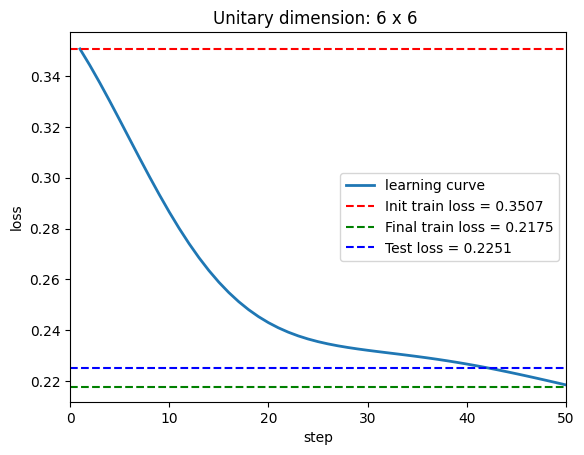

In [ ]:
# Initialize the phases
init_phases = circ.initialize_phases(10, 2*g.num_features, )  
weights_data = g.jnp.ones(shape = [init_phases.shape[0],init_phases.shape[1]])
# Initialize the carry for Adam.
init = (init_phases, train_set, train_labels, weights_data, 0.0*init_phases, 0.0*init_phases, 0.0*weights_data, 0.0*weights_data)

# Run the training, and output  time taken.
b = g.time.time()
carry, loss_mem = g.jax.block_until_ready(train.train(init))
e = g.time.time()
print('Training with, num_features: ', g.num_features, 
      ', num_steps: ', g.num_steps,
        ', took ', (e-b)/60, ' minutes')

# Loss Before/After on train set + Loss on test set
trained_phases, trained_weights = carry[0], carry[3]
init_loss = loss.loss(init_phases, train_set, train_labels, weights_data)
train_loss = loss.loss(trained_phases, train_set, train_labels, trained_weights)
test_loss = loss.loss(trained_phases, test_set, test_labels, trained_weights)

# plotting the learning curve
fig, ax = g.plt.subplots()
ax.plot(g.np.array(loss_mem[:,0]), g.np.array(loss_mem[:,1]), linewidth=2, label=r"learning curve" )
ax.set(xlim = (0,globals.num_steps), xlabel="step", ylabel = "loss",)
ax.axhline(init_loss, color='r', linestyle='--', label=f"Init train loss = {init_loss:.4f}")
ax.axhline(train_loss, color='g', linestyle='--', label=f"Final train loss = {train_loss:.4f}")
ax.axhline(test_loss, color='b', linestyle='--', label=f"Test loss = {test_loss:.4f}")
unitary_shape = trained_phases.shape  
ax.set_title(f"Unitary dimension: {2*unitary_shape[1]} x {2*unitary_shape[1]} ")
ax.legend()
g.plt.show()

## Training Loss - Multi Depth

In [75]:
depth_list = [4, 5, 6] # depth = number of layers

Training with depth = 4
Training with depth = 5
Training with depth = 6


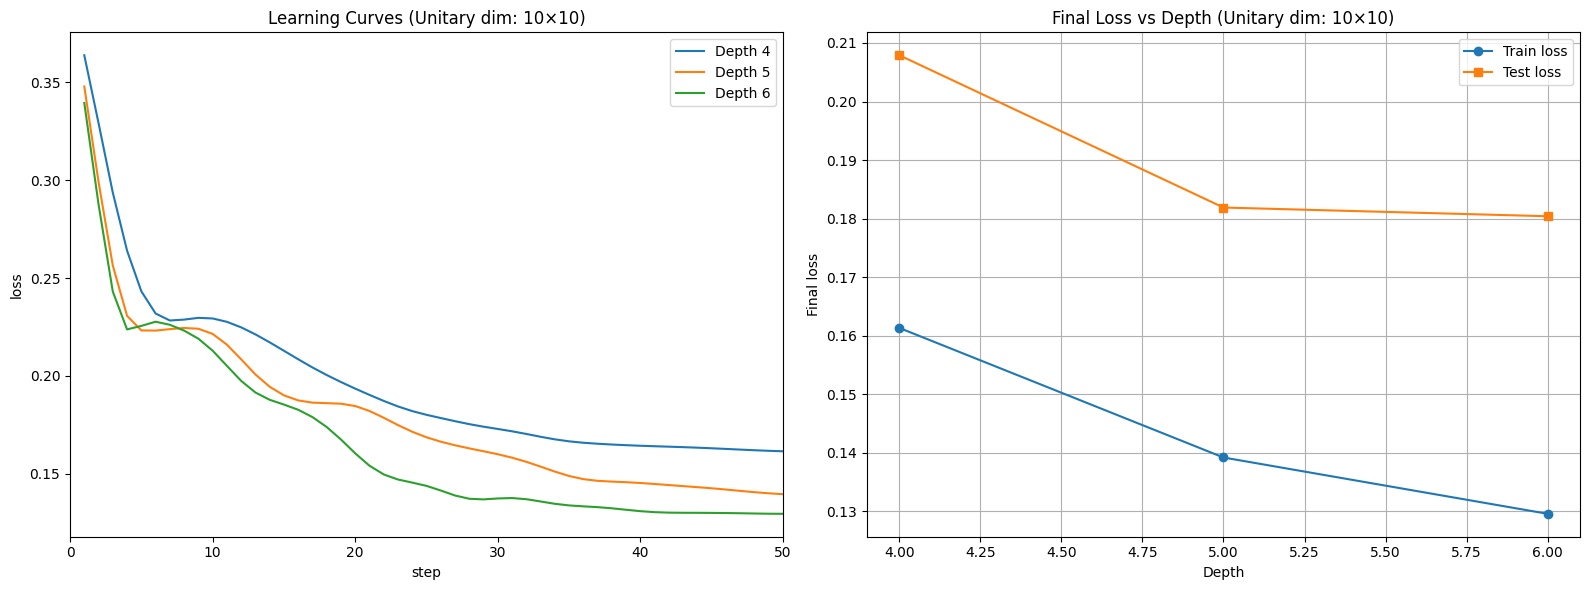

 depth  train_loss_before  train_loss_after  test_loss_after  init_time_min  loss_time_min  train_time_min  total_time_min
     4             0.3638            0.1613           0.2079         0.0033         1.3913          0.1600          1.5546
     5             0.3478            0.1392           0.1819         0.0090         1.4336          0.2392          1.6818
     6             0.3394            0.1296           0.1804         0.0045         1.4642          0.4352          1.9039


In [86]:
results = []; fig, (ax1, ax2) = g.plt.subplots(1, 2, figsize=(16, 6))
for depth in depth_list:
    print(f"Training with depth = {depth}"); 
    #initialize parameters
    a = g.time.time()
    init_phases = circ.initialize_phases(depth, 2*g.num_features)
    weights_data = g.jnp.ones(shape=[init_phases.shape[0], init_phases.shape[1]])
    init = ( init_phases, train_set, train_labels, weights_data,0.0*init_phases, 0.0*init_phases, 0.0*weights_data, 0.0*weights_data)
    # Run the training.
    b = g.time.time()
    carry, loss_mem = g.jax.block_until_ready(train.train)(init)
    # Loss Before/After on train set + Loss on test set
    c = g.time.time()
    trained_phases, trained_weights = carry[0], carry[3]
    init_loss, train_loss, test_loss = float(loss.loss(init_phases, train_set, train_labels, weights_data)), float(loss.loss(trained_phases, train_set, train_labels, trained_weights)), float(loss.loss(trained_phases, test_set, test_labels, trained_weights))
    d = g.time.time()
    #plot learning curve for given depth
    ax1.plot(g.np.array(loss_mem[:,0]), g.np.array(loss_mem[:,1]), label=f"Depth {depth}")
    #timing calcs
    init_time_min, train_time_min, loss_time_min, total_time_min = (b-a)/60, (c-b)/60, (d-c)/60, (d-a)/60
    #append results
    results.append({"depth": depth, "train_loss_before": init_loss, "train_loss_after": train_loss, "test_loss_after": test_loss, 
                    "init_time_min": init_time_min, "loss_time_min": loss_time_min, "train_time_min": train_time_min,"total_time_min": total_time_min})
# Finalize left subplot
ax1.set_xlim(0, g.num_steps)
ax1.set_xlabel("step"); ax1.set_ylabel("loss")
ax1.set_title(f"Learning Curves (Unitary dim: {2*init_phases.shape[1]}×{2*init_phases.shape[1]})")
ax1.legend()
# Prepare data for right subplot (final losses vs depth)
depth_vals, train_vals, test_vals = [r["depth"] for r in results], [r["train_loss_after"] for r in results], [r["test_loss_after"] for r in results]
# Plot final losses vs depth
ax2.plot(depth_vals, train_vals, 'o-', label="Train loss"); ax2.plot(depth_vals, test_vals,  's-', label="Test loss")
ax2.set_xlabel("Depth"); ax2.set_ylabel("Final loss")
ax2.set_title(f"Final Loss vs Depth (Unitary dim: {2*init_phases.shape[1]}×{2*init_phases.shape[1]})")
ax2.grid(True)
ax2.legend()
g.plt.tight_layout()
g.plt.show()
# Create and print the results table
results_df = g.pd.DataFrame(results)
print(results_df.to_string(index=False, float_format="%.4F"))

## Training Loss - Multi Feature

In [87]:
feature_dims = [3,4,5]
depth = 5  # Set your desired constant depth here

Training with 3 features (depth=5)
Training with 4 features (depth=5)
Training with 5 features (depth=5)


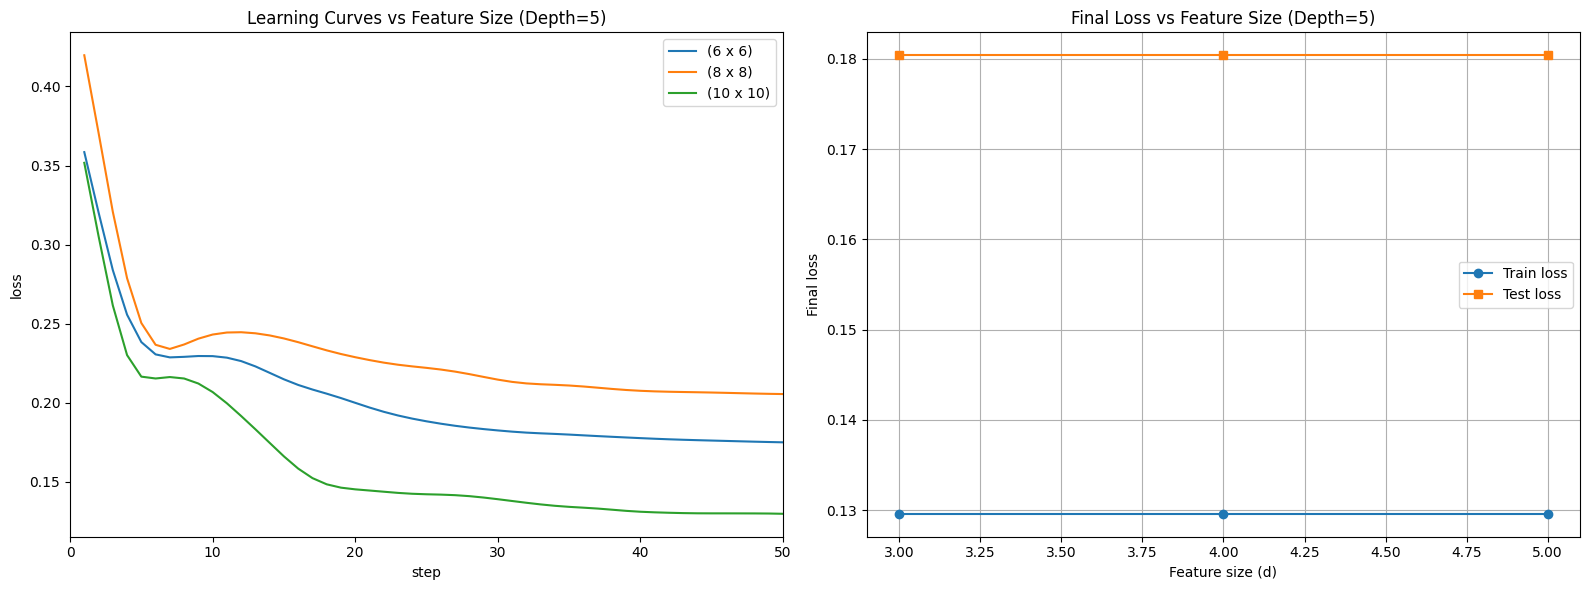

 features  train_loss_before  train_loss_after  test_loss_after  load_data_time_min  init_time_min  loss_time_min  train_time_min  total_time_min
        3             0.3394            0.1296           0.1804              0.0043         0.0007         0.2720          0.0009          0.2778
        4             0.3394            0.1296           0.1804              0.0025         0.0062         0.6759          0.1472          0.8318
        5             0.3394            0.1296           0.1804              0.0027         0.0005         1.1441          0.0004          1.1478


In [ ]:
results = []
fig, (ax1, ax2) = g.plt.subplots(1, 2, figsize=(16, 6))
for f_dims in feature_dims:
    print(f"Training with {f_dims} features (depth={depth})")
    # making sure to change num_features in globals file as all other files refernce from there
    g.num_features = f_dims
    # Load, split and rescale data for the current feature dimension
    a = g.time.time()
    split_data = globals.load_and_split_data(f_dims)
    train_set, train_labels, test_set, test_labels = split_data
    train_set = pre_p.rescale_data(train_set, min_val = -(g.np.pi)/2, max_val = (g.np.pi/2))
    test_set = pre_p.rescale_data(test_set, min_val = -(g.np.pi)/2, max_val = (g.np.pi/2))
    # Initialize the phases and weights
    b = g.time.time()
    init_phases = circ.initialize_phases(depth, 2*f_dims)
    weights_data = g.jnp.ones(shape=[init_phases.shape[0], init_phases.shape[1]])
    init = (init_phases, train_set, train_labels, weights_data, 0.0*init_phases, 0.0*init_phases, 0.0*weights_data, 0.0*weights_data)
    # training
    c = g.time.time()
    carry, loss_mem = g.jax.block_until_ready(train.train)(init)
    # Loss Before/After on train set + Loss on test set
    d = g.time.time()
    trained_phases, trained_weights  = carry[0], carry[3]
    init_loss, train_loss, test_loss = float(loss.loss(init_phases, train_set, train_labels, weights_data)), float(loss.loss(trained_phases, train_set, train_labels, trained_weights)), float(loss.loss(trained_phases, test_set, test_labels, trained_weights))
    # time calcs
    e = g.time.time()
    load_data_time_min, init_time_min, train_time_min, loss_time_min, total_time_min = (b-a)/60, (c-b)/60, (d-c)/60, (e-d)/60, (e-a)/60
    #plot data
    ax1.plot(g.np.array(loss_mem[:,0]), g.np.array(loss_mem[:,1]), label=f"({2*f_dims} x {2*f_dims})")
    #store results
    results.append({"features": f_dims, "train_loss_before": init_loss, "train_loss_after": train_loss, "test_loss_after": test_loss, 
                    "load_data_time_min": load_data_time_min, "init_time_min": init_time_min, "loss_time_min": loss_time_min, "train_time_min": train_time_min,"total_time_min": total_time_min})
# finalize left subplot
ax1.set_xlim(0, g.num_steps); ax1.set_xlabel("step"); ax1.set_ylabel("loss")
ax1.set_title(f"Learning Curves vs Feature Size (Depth={depth})"); ax1.legend()
# prepare and plot final losses vs feature size
f_vals = [r["features"] for r in results]; tr = [r["train_loss_after"] for r in results]; te = [r["test_loss_after"] for r in results]
ax2.plot(f_vals, tr, 'o-', label="Train loss"); ax2.plot(f_vals, te, 's-', label="Test loss")
ax2.set_xlabel("Feature size (d)"); ax2.set_ylabel("Final loss")
ax2.set_title(f"Final Loss vs Feature Size (Depth={depth})"); ax2.grid(True); ax2.legend()
g.plt.tight_layout(); g.plt.show()
# print results table
results_df = g.pd.DataFrame(results); print(results_df.to_string(index=False, float_format="%.4F"))